In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [1]:
!pip install gputil
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 27% |


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print('version :' , torch.__version__)
print('cuda :' , torch.cuda.is_available())
print('cudnn :' , torch.backends.cudnn.enabled)

version : 1.0.0
cuda : True
cudnn : True


In [4]:
EPOCH = 100
BATCH_SIZE = 200
LR = 0.001
DOWNLOAD_data = True

In [6]:
train_data = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    transform=torchvision.transforms.ToTensor(), #改成torch可讀
    download=DOWNLOAD_data,
)


50000
50000


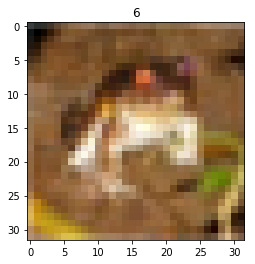

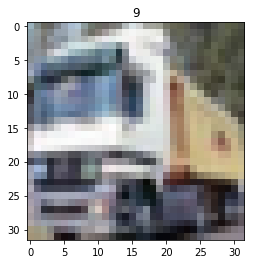

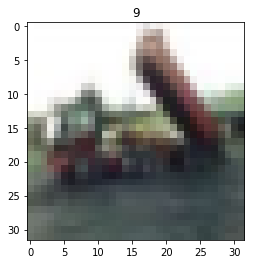

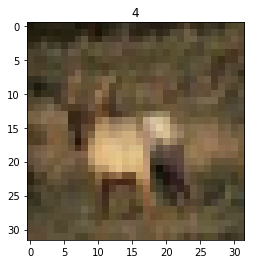

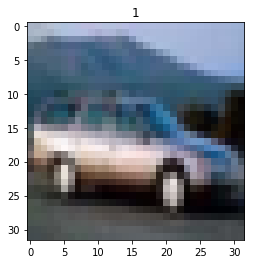

In [7]:
print(len(train_data.train_data))
print(len(train_data.train_labels))
for i in range(5):    
    img = np.asarray(train_data.train_data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % train_data.train_labels[i])
    plt.show()

In [8]:
test_data = torchvision.datasets.CIFAR10(root='./data/',
                              train=False,
                              transform=torchvision.transforms.ToTensor())

10000
3000


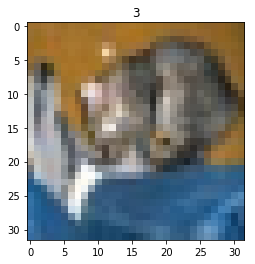

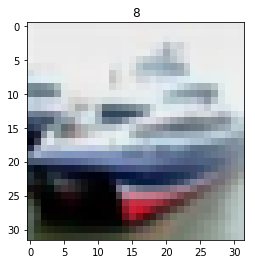

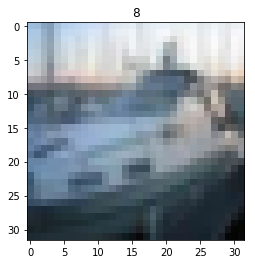

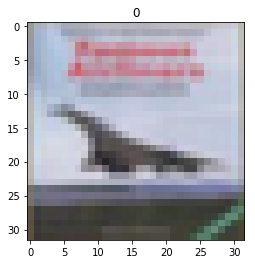

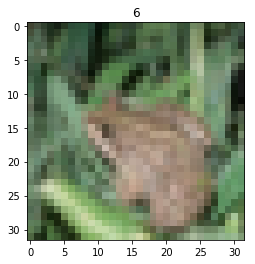

In [9]:
print(len(test_data.test_data))
test_data.test_data = test_data.test_data[:3000]
test_data.test_labels = test_data.test_labels[:3000]
print(len(test_data.test_data))
for i in range(5):    
    img = np.asarray(test_data.test_data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % test_data.test_labels[i])
    plt.show()

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)
print(train_loader)
print(len(train_loader))
print(test_loader)
print(len(test_loader))

250
15


In [22]:
#test_data = torchvision.datasets.CIFAR10(root='./data/', train=False)
#print(type(test_data.test_data))

############
#i dont's know way this type was 'numpy.ndarray', so i convert it myself
#test_data.test_data = torch.unsqueeze(torch.from_numpy(test_data.test_data), dim=3)
print(type(test_data.test_data))
#print(len(test_data.test_data))
############
img,lab = train_loader.dataset[0]
print(type(lab))


<class 'torch.Tensor'>
<class 'int'>


In [13]:
class InceptionA(nn.Module):
    def __init__(self,in_channels):
        super(InceptionA, self).__init__()
        self.conv1 = nn.Sequential(       # input  (3,_,_)
            nn.AvgPool2d(3,1,1),          # output  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
        )
        self.conv2 = nn.Sequential(       # input  (3,_,_)
            nn.MaxPool2d(3,1,1),          # output  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
        )
        
        self.conv3 = nn.Sequential(       # input  (3,_,_)
            nn.Conv2d(in_channels,16,1),  # output  (16,_,_)
            nn.Conv2d(16,16,5,1,2),       # output  (16,_,_)
        )
        
        self.conv4 = nn.Sequential(       # input  (3,_,_)
            nn.Conv2d(in_channels,8,1),   # output  (8,_,_)
            #nn.Conv2d(16,24,3,1,1),      # output  (24,_,_)
            nn.Conv2d(8,16,3,1,1),        # output  (16,_,_)
        )
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        
        outputs = [x2,x3,x4,x1]
        #outputs = [x3,x4,x1]#72
        
        return torch.cat(outputs,1)       # output  (16*4, 32, 32)<<
                                          # output  (88, 32, 32)<<
####################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(       # input  (3, 32, 32)
            nn.Conv2d(3,20,5,1,2),        # output  (20, 32, 32)
            InceptionA(in_channels=20),   # output  (64, 32, 32)
            nn.MaxPool2d(2),              # output  (64, 16, 16)
        )
        self.conv2 = nn.Sequential(       # input  (64, 16, 16)
            nn.Conv2d(64,40,5,1,2),       # output  (40, 16, 16)
            InceptionA(in_channels=40),   # output  (64, 16, 16)
            nn.MaxPool2d(2),              # output  (64, 8, 8)
        )
        
        self.out1 = nn.Linear(64*8*8, 512) #fully connected layer
        self.out2 = nn.Linear(512, 128)
        self.out3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = x.view(-1, 32 * 8 * 8)
        x = x.view(x.size(0), -1)
        x = self.out1(x)
        x = self.out2(x)
        x = self.out3(x)
        #output = nn.functional.log_softmax(x, dim=1)
        return x    # return x for visualization

In [14]:
cnn = CNN()
cnn.cuda()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InceptionA(
      (conv1): Sequential(
        (0): AvgPool2d(kernel_size=3, stride=1, padding=1)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv2): Sequential(
        (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv3): Sequential(
        (0): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (conv4): Sequential(
        (0): Conv2d(20, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 40, kernel_size=(5, 5), stride=(1, 1), paddin

In [15]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [16]:
def train(epoch):
    for step, (x, y) in enumerate(train_loader):
        data = Variable(x).cuda()   # batch x
        target = Variable(y).cuda()   # batch y

        output = cnn(data)               # cnn output
        #loss = nn.functional.nll_loss(output, target)
        loss = loss_func(output, target)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
           step * len(data), len(train_loader.dataset),100. * step / len(train_loader), loss.data.item()))
    print("Finish")
    GPUtil.showUtilization()
    
Epoch = np.arange(EPOCH-1)
Loss = np.arange(0)
Accuracy = np.arange(0)

#Loss = np.append(Loss,0.343534543534)
#print(Loss)


def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = cnn(data)
        # sum up batch loss
        los = loss_func(output, target)
        #print(los)
        test_loss += los
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    #print(test_loss)
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    #print(float(test_loss))
    global Loss
    global Accuracy
    Loss = np.append(Loss,float(test_loss))
    #print(Loss)
    Accuracy = np.append(Accuracy,float(100. * correct / len(test_loader.dataset)))
    
    GPUtil.showUtilization()

In [18]:
for epoch in range(1,EPOCH):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.346114
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.236579
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.279116
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.137949
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.174237
Finish
| ID | GPU | MEM |
------------------
|  0 | 99% | 41% |


AttributeError: 'Tensor' object has no attribute '__array_interface__'

In [17]:
#torch.save(cnn, 'net.pkl')
#torch.save(cnn.state_dict(), 'net_params.pkl')
print(Epoch)
print(Loss)
print(Accuracy)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
[1.31980443 1.09558547 1.02235234 0.95548898 0.94298059 0.94437373
 0.88832909 0.92933905 0.91440892 0.94479752 0.9561168  0.96093535
 1.00310636 1.06981719 1.0178498  1.10169351 1.08896208 1.2056495
 1.19884789 1.2973156  1.39482236 1.38848603 1.41691709 1.5084796
 1.53965473 1.61303353 1.59939957 1.72552848 1.74444687 1.74852061
 1.87297785 1.91668928 1.97731066 1.97840405 1.98605645 2.12018704
 2.14752865 2.23003221 2.16409612 2.28664446 2.29836893 2.24463582
 2.42530942 2.40316844 2.45766783 2.49814749 2.46743298 2.57469392
 2.37514257 2.75413465 2.62188125 2.55679393 2.56489015 2.685987
 2.58110189 2.63690877 2.65965676 2.83051562 2.68817663 2.62690544
 2.7176857  2.84532547 2.901898

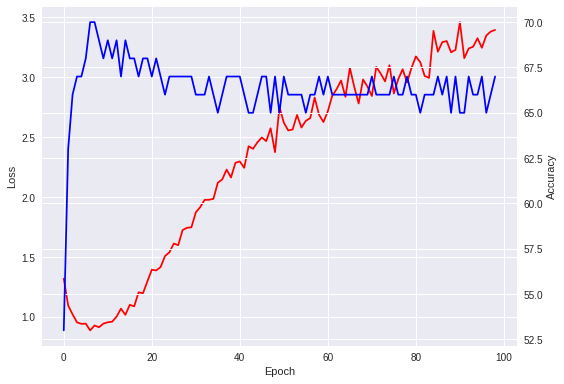

In [18]:
#plot

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(Epoch, Loss, color='red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(Epoch, Accuracy,color='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

